# General trace loader
Interface for loading various traces. Tasks include:
- Resolving class imbalance (TODO)
- Noise reduction (TODO)

In [78]:
import pandas as pd
import seaborn as sns
import numpy as np
from tqdm import tqdm

from src.tools.cache import cache_np
from src.tools.nbloader import NotebookLoader
from src.data.traceloader import ASCAD, TraceGroup

sns.set_style("whitegrid")

KEY_SIZE = 256

In [79]:
ascad = ASCAD()
ascad.default.profile.traces.shape

(50000, 700)

In [80]:
ascad.default.profile.filter_by_key(1).shape

(180, 700)

<AxesSubplot:>

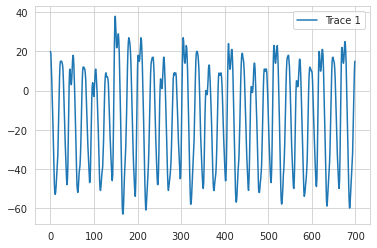

In [81]:
T1 = ascad.default.profile.traces[0]
sns.lineplot(data=pd.DataFrame(T1, columns=["Trace 1"]))

### Plot of a small section of two traces

<AxesSubplot:>

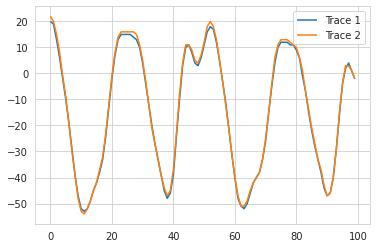

In [82]:
T2 = ascad.default.profile.traces[1]
sns.lineplot(dashes=[(1, 0), (1, 0)], data=pd.DataFrame(list(zip(T1, T2))[:100], columns=["Trace 1", "Trace 2"]))

### Mean of ASCAD traces.

In [83]:
print(f"Profiling trace mean: {ascad.default.profile.traces.mean():.2f},\n"
      f"Attack trace mean: {ascad.default.attack.traces.mean():.2f}")

Profiling trace mean: -11.59,
Attack trace mean: -11.56


### Variance of ASCAD traces.

In [84]:
print(f"Profiling trace variance: {ascad.default.profile.traces.var():.2f},\n"
      f"Attack trace variance: {ascad.default.attack.traces.var():.2f}")

Profiling trace variance: 663.22,
Attack trace variance: 663.41


### Mean and variance between all traces.

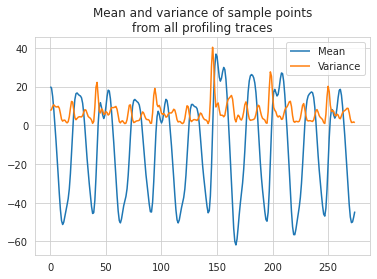

In [85]:
import matplotlib.pyplot as plt

DEFAULT_CUTOFF = 275

def plot_mv_traces(traces, cutoff=DEFAULT_CUTOFF):
    df_mv = pd.DataFrame(list(zip(traces.mean(axis=0), traces.var(axis=0)))[:cutoff], columns=["Mean", "Variance"])

    title = "Mean and variance of sample points\nfrom all profiling traces"
    sns.lineplot(dashes=[(1, 0), (1, 0)], data=df_mv).set_title(title)

def mv_diff(left, right):
    mean_diff = left.mean(axis=0) - right.mean(axis=0)
    var_diff = left.var(axis=0) - right.var(axis=0)

    return mean_diff, var_diff

def plot_mv_diff(left, right, title, cutoff=DEFAULT_CUTOFF):
    cols = ["Mean difference", "Variance difference"]
    df_mv_diff = pd.DataFrame(list(zip(*mv_diff(left, right)))[:cutoff], columns=cols)
    sns.lineplot(data=df_mv_diff[cols[0]])

    ax2 = plt.twinx()
    sns.lineplot(data=df_mv_diff[cols[1]], color=sns.color_palette()[1], ax=ax2).set_title(title)


plot_mv_traces(ascad.default.profile.traces)

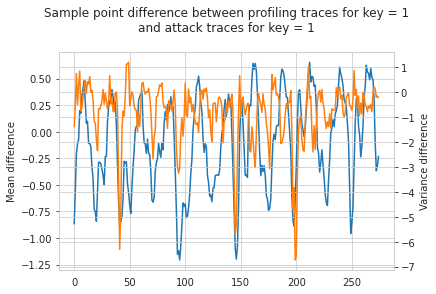

In [86]:
TITLE = "Sample point difference between profiling traces for key = 1\nand attack traces for key = 1\n"
plot_mv_diff(ascad.default.profile.filter_by_key(1), ascad.default.attack.filter_by_key(1), TITLE)


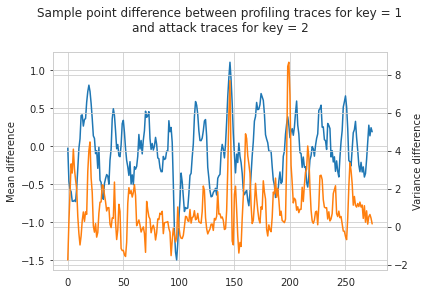

In [87]:
TITLE = "Sample point difference between profiling traces for key = 1\nand attack traces for key = 2\n"
plot_mv_diff(ascad.default.profile.filter_by_key(1), ascad.default.attack.filter_by_key(2), TITLE)

In [88]:
poi = NotebookLoader(["../data"]).load_module("poi")

importing Jupyter notebook from ../data/poi.ipynb


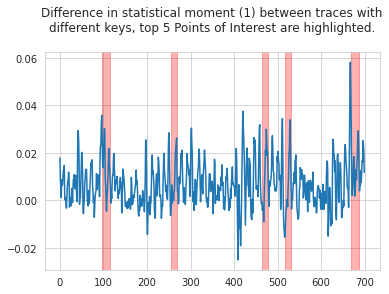

array([[669, 688],
       [ 97, 116],
       [464, 479],
       [516, 531],
       [255, 270]])

In [89]:
poi.plot_poi(poi.MOMENT_DIFFERENCES, 1)
poi.select_poi(poi.MOMENT_DIFFERENCES[1])

### PoI for the variance

`TODO` What does the big spike at 200 mean?

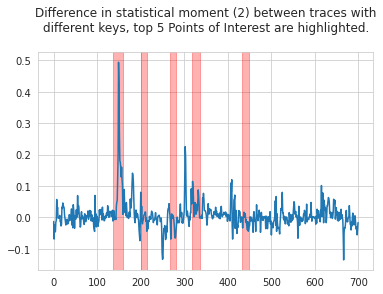

In [90]:
poi.plot_poi(poi.MOMENT_DIFFERENCES, 2)

### PoI for the skewness

`TODO` How to improve the PoI selection?

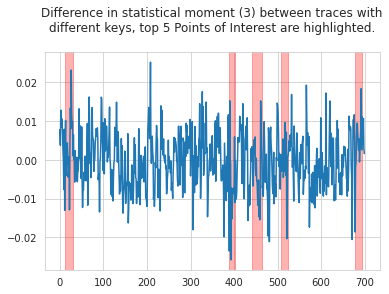

In [91]:
poi.plot_poi(poi.MOMENT_DIFFERENCES, 3)

### Close up of the first PoI

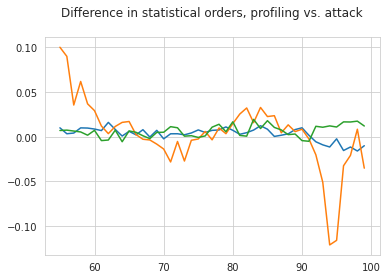

In [92]:
def select_range(line, a=55, b=100):
    return dict(zip(range(a, b), line[a:b]))

sns.lineplot(data=select_range(poi.TRUE_MDIFF[1])).set_title(
    "Difference in statistical orders, profiling vs. attack\n")
sns.lineplot(data=select_range(poi.TRUE_MDIFF[2]))
sns.lineplot(data=select_range(poi.TRUE_MDIFF[3]))

print()

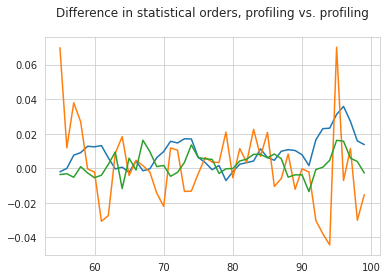

In [93]:
sns.lineplot(data=select_range(poi.MOMENT_DIFFERENCES[1])).set_title(
    "Difference in statistical orders, profiling vs. profiling\n")
sns.lineplot(data=select_range(poi.MOMENT_DIFFERENCES[2]))
sns.lineplot(data=select_range(poi.MOMENT_DIFFERENCES[3]))

print()

# TVLA

### Implementation of $\chi^2$-test

In [94]:
import scipy.stats as stats

def count(traces, poi=None, trace_range=256, offset=-.5, max_bins=64):
    pos_traces = traces + round(-trace_range * offset)

    if poi is None:
        poi = (0, traces.shape[1])

    bin_count = np.sum(np.array([np.bincount(sample_pts[poi[0]:poi[1]], minlength=trace_range) for sample_pts in pos_traces]), axis=0)

    res = np.zeros(max_bins)
    step = round(trace_range / max_bins)

    for ix in range(max_bins):
        res[ix] = np.sum(bin_count[ix * step:(ix + 1) * step])

    return res


### Test examples from paper
Moriadi et al. (2018), page 214


In [95]:
# Example values from Moriadi et al. (2018), page 214
MORIADI = {
    'F_0': [24, 59, 28, 9],
    'F_1': [23, 57, 20, 0],
    'chi': 8.64,
    'dof': 3,
    'p': 0.0345,
    'p_decimal': 3
}

### Implementation based on paper
Moriadi et al. (2018), page 213

In [96]:
import math
from scipy.integrate import quad
from numpy.testing import assert_almost_equal as almost_equal

def f_chi(x, v):
    if x <= 0:
        return 0

    num = x ** ((v / 2) - 1) * math.e ** (-x / 2)
    den = 2 ** (v / 2) * math.gamma(v / 2)
    return num / den

def p_chi(sum_chi, dof):
    return quad(f_chi, sum_chi, np.inf, args=(dof, ))[0]

almost_equal(p_chi(MORIADI['chi'], MORIADI['dof']), MORIADI['p'], MORIADI['p_decimal'])

def chi_squared(observed, expected, balance=False):
    categories = np.array([observed, expected])

    # Expected frequency
    sum_cat = np.sum(observed), np.sum(expected)

    sum_oe = np.sum(categories, axis=0)

    sum_all = np.sum(sum_oe)
    nz_ixs = np.nonzero(sum_oe)[0]

    chi_acc = 0.0
    for cat in range(len(categories)):
        for ix in nz_ixs:
            # Expected frequency
            ef = (sum_cat[cat] * sum_oe[ix]) / sum_all
            # Accumulation of chi-squared value
            chi_acc += (categories[cat][ix] - ef) ** 2 / ef

    # Degrees of freedom.
    dof = (len(nz_ixs) - 1) * (len(categories) - 1)

    # return chi_acc, dof
    return p_chi(chi_acc, dof)

almost_equal(chi_squared(MORIADI['F_0'], MORIADI['F_1']), MORIADI['p'], MORIADI['p_decimal'])


### Application of $\chi^2$ on ASCAD, with selected PoI

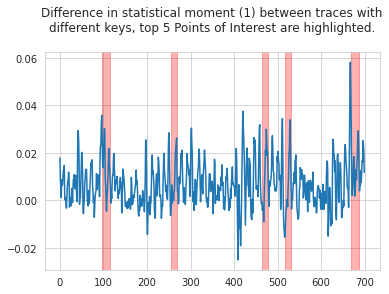

TypeError: 'int' object is not subscriptable

In [100]:
def mdiff_poi(tg: TraceGroup, moment_differences, moment=1, left=1, right=1):
    trace_l = tg.profile.filter_by_key(left)
    trace_r = tg.attack.filter_by_key(right)

    acc = []
    poi_ranges = poi.select_poi(moment_differences[moment])
    for ix in range(len(poi_ranges)):
        pois = poi_ranges[ix]
        p_value = 1 - chi_squared(count(trace_l, pois), count(trace_r, pois))
        acc.append((pois, p_value))

    return acc

poi.plot_poi(poi.MOMENT_DIFFERENCES, 1)
mdiff_poi(ascad.random, 1, 1, 1)

In [ ]:
1 - chi_squared(count(ascad.default.profile.filter_by_key(1), [429, 447]),
            count(ascad.default.attack.filter_by_key(1), [429, 447]))

In [ ]:
1 - chi_squared(count(ascad.default.profile.filter_by_key(2), [429, 447]),
            count(ascad.default.attack.filter_by_key(1), [429, 447]))

In [ ]:
1 - chi_squared(count(ascad.default.profile.filter_by_key(3), [429, 447]),
            count(ascad.default.attack.filter_by_key(1), [429, 447]))

### What does the $p$-value of $\chi^2$ squared mean?

Seen below, $\chi^2$ is low for many places.

### chi-squared sliding window

In [ ]:
def sliding_window(tg: TraceGroup, key_l=1, key_r=1, progress=True):
    trace_l = tg.profile.filter_by_key(key_l)
    trace_r = tg.attack.filter_by_key(key_r)

    window = 50
    trace_size = 1400
    acc = []

    window_ixs = range(0, trace_size - window)
    if progress:
        window_ixs = tqdm(window_ixs)

    for ix in window_ixs:
        poi = (ix, ix + window)
        p_value = 1 - chi_squared(count(trace_l, poi), count(trace_r, poi))
        acc.append((ix, p_value))

    return acc

SW_EQ = sliding_window(ascad.default)

### Experiments with sliding window on $\chi^2$

With a sliding window over only 1, a

In [ ]:
sns.lineplot(data=poi.MOMENT_DIFFERENCES[1])
ax2 = plt.twinx()
sns.lineplot(data=[*([np.nan] * 25), *list(zip(*SW_EQ))[1]], color='orange')

# TODO Next steps:

- Calculate chi again for entire trace (set count to cover entire trace).
- Figure out if the low values for $\chi^2$ outside PoI are good or bad.
- Come up with proper PoI system

### Results for $\chi^2$-test

In [ ]:
def get_chi_p(poi=(52, 81), progress=False):
    counts_prof = [count(ascad.default.profile.filter_by_key(i), poi) for i in range(KEY_SIZE)]
    counts_att = [count(ascad.default.attack.filter_by_key(i), poi) for i in range(KEY_SIZE)]

    chi_p = np.array([np.zeros(KEY_SIZE)] * KEY_SIZE)

    key_range = range(KEY_SIZE)
    if progress:
        key_range = tqdm(key_range)

    for i in key_range:
        for j in range(KEY_SIZE):
            chi_p[i][j] = 1 - chi_squared(counts_prof[i], counts_att[j])

    return chi_p

def sliding_window_chi_p_all(window_size=50, step=5):
    acc = []
    for ix in tqdm(range(0, 1400-window_size, step)):
        acc.append(get_chi_p((ix, ix + window_size)))

    return acc

CHI_P_SW = cache_np('sliding_window_chi_p_all', sliding_window_chi_p_all)

### $\chi^2$ p-values over sliding window

can be found in `ascad_chi.ipynb`.

In [ ]:
CHI_P_ALL = get_chi_p(progress=True)

AVG_SUM_DIFF = 0
SUM_EQ = 0
for i in range(KEY_SIZE):
    SUM_EQ += CHI_P_ALL[i][i]
    for j in range(KEY_SIZE):
        if j != i:
            AVG_SUM_DIFF += CHI_P_ALL[i][j]

AVG_SUM_DIFF /= KEY_SIZE ** 2 - KEY_SIZE
SUM_EQ /= KEY_SIZE

AVG_SUM_DIFF, SUM_EQ

### Important discovery for $\chi^2$
Twice the number of observations from the same distribution will decimate the p-value.
*In this example: from from $1.0$ to $0.23$*
The number of observed sample point values in the attack set should therefore be multiplied with
$\frac{\text{#traces in profiling set}}{\text{#traces in attack set}}$ to obtain a proper p-value.

In [ ]:
A = np.array([1, 2, 5, 2, 1])
print(stats.chisquare(A, f_exp=A))
print(stats.chisquare(A, f_exp=A * 2))

# Next steps

- Leakage moment detector for statistical moments?

In [ ]:
# Under construction
stats.moment(ascad.random.profile.traces, 2)

In [ ]:
# from src.settings.nbloader import NotebookLoader
# nb = NotebookLoader().load_module("tvla.classic_la")

### $t$ test
The aim of a t-test is to provide a quantitative value as a probability that the mean μ of two sets are different.

For the $t$-test, high $p$ values give reason to reject H0 being "left and right are from different distributions". The traces should be normally distributed for the
    Student's t-test to work.


In [ ]:
# print("exact: ", nb.calc_t([prof_group.contingency_table(1), prof_group.contingency_table(1)]))
# print("same:  ", nb.calc_t([prof_group.contingency_table(1), att_group.contingency_table(1)]))
# print("diff:  ", nb.calc_t([prof_group.contingency_table(1), att_group.contingency_table(2)]))

### $\chi^2$ test

For $\chi^2$, small p-values give reason to reject $H_0$ =
"the occurrences of these observations are independent".
For $t$, large p-values give reason to reject $H_0$ =
"the samples in both sets are drawn from the same population".

In [ ]:
# print("exact: ", nb.calc_chi([prof_group.contingency_table(1), prof_group.contingency_table(1)]))
# print("same:  ", nb.calc_chi([prof_group.contingency_table(1), att_group.contingency_table(1)]))
# print("diff:  ", nb.calc_chi([prof_group.contingency_table(1), att_group.contingency_table(2)]))

# Failed hypotheses

### Correlation between mean and variance for equal / different traces is important

In [ ]:
np.array([np.corrcoef(mv_diff(ascad.default.profile.filter_by_key(i),
                              ascad.default.attack.filter_by_key(i)))[0][1] for i in range(256)]).mean()

In [ ]:
np.array([np.corrcoef(mv_diff(ascad.default.profile.filter_by_key(1),
                              ascad.default.attack.filter_by_key(i)))[0][1] for i in range(256)]).mean()

Differences (1st order statistical moment) and variances (2nd order statistical moment)

In [ ]:
def gen_diff(group: TraceGroup, order=1):
    keys = range(256)
    att_all = poi.stat_order(group.attack.traces, order)
    mean_acc_diff = np.zeros(len(keys))

    for key in keys:
        prof_key = poi.stat_order(group.profile.filter_by_key(key), order)
        att_key = poi.stat_order(group.attack.filter_by_key(key), order)

        mean_acc_diff[key] = abs(prof_key - att_key).mean() - abs(prof_key - att_all).mean()

    return mean_acc_diff

In [ ]:
_ = sns.boxplot(data=pd.DataFrame({
    "Key vs. all": gen_diff(ascad.default),
    "Randomized": gen_diff(ascad.random)
}), showfliers = False).set_title('First order statistical moment')

In [ ]:
_ = sns.boxplot(data=pd.DataFrame({
    "Key vs. all": gen_diff(ascad.default, 2),
    "Randomized": gen_diff(ascad.random, 2)
}), showfliers = False).set_title('Second order statistical moment')